(Please note that this notebook along with the whole repository is a work in progress, I will be well documenting it as soon as possible <3 )

In [23]:
import os
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import collections
import cv2
import matplotlib.pyplot as plt
import gym
from gym import wrappers
import ale_py

In [98]:
class ReplayBuffer(object):
    def __init__(self, mem_size, input_shape):
        self.mem_size = mem_size
        self.input_shape = input_shape
        self.mem_cntr = 0
        
        self.state_memory = np.zeros((self.mem_size, *self.input_shape), 
                                     dtype = np.float32) #To save current state
        
        self.next_state_memory = np.zeros((self.mem_size, *self.input_shape), 
                                     dtype = np.float32) #To save next state
        
        self.action_memory = np.zeros(self.mem_size, dtype = np.int64)
                                                        #To save actions
        
        self.reward_memory = np.zeros(self.mem_size, dtype = np.float32)
                                                        #To save rewards(not necessarily integers)
        self.done_memory = np.zeros(self.mem_size, dtype = bool)
                                                        #To save done flag
        
    def store_items(self, s, a, r, s_, d):
        idx = self.mem_cntr % self.mem_size
        
        self.state_memory[idx] = s
        self.next_state_memory[idx] = s_
        self.action_memory[idx] = a
        self.reward_memory[idx] = r
        self.done_memory[idx] = d
        
        self.mem_cntr += 1
        
    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace = False)
                                    #batch_size is necessarily smaller than max_mem
        
        s = self.state_memory[batch]
        s_ = self.next_state_memory[batch]
        a = self.action_memory[batch]
        r = self.reward_memory[batch]
        d = self.done_memory[batch]
        
        return s, a, r, s_, d        

In [99]:
class DQN(nn.Module):
    def __init__(self, lr, n_actions, input_dims, name, chkpt_dir):
        super(DQN, self).__init__()
        self.chkpt_dir = chkpt_dir
        self.name = name
        self.checkpoint_file = os.path.join(self.chkpt_dir, self.name)
        
        self.conv1 = nn.Conv2d(input_dims[0], 16, 8, stride = 4)
        self.relu1 = nn.ReLU(inplace = True)
        self.conv2 = nn.Conv2d(16, 32, 4, stride = 2)
        self.relu2 = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(self.calculate_input(input_dims), 256)
        self.relu2 = nn.ReLU(inplace = True)
        self.fc2 = nn.Linear(256, n_actions)
        self.relu3 = nn.ReLU(inplace = True)
        
        self.optimizer = optim.Adam(self.parameters(), lr = lr)
        
        self.loss = nn.MSELoss()
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
        self.to(self.device)
        
        
    def calculate_input(self, input_dims):
        state = torch.zeros(1, *input_dims)
        dims = self.conv1(state)
        dims = self.conv2(dims)
        return int(np.prod(dims.size()))
    
    def forward(self, state):
        x = self.relu2(self.conv2(self.relu1(self.conv1(state))))
        x = x.view(x.size()[0], -1)
        action_values = self.fc2(self.relu3(self.fc1(x)))
        return action_values
    
    def save_checkpoint(self):
        print('...saving checkpoint...')
        torch.save(self.state_dict(), self.checkpoint_file)
    
    def load_checkpoint(self):
        print('...loading checkpoint...')

In [104]:
class Agent(object):
    def __init__(self, gamma, eps, lr, n_actions, input_dims, mem_size,
                 batch_size, target_with_network = True, eps_min=0.01, 
                 eps_dec = 5e-7, replace = 1000, chkpt_dir = 'dqn'):
        self.gamma = gamma
        self.lr = lr
        self.eps = eps
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.n_actions = n_actions
        self.replace = replace
        self.input_dims = input_dims
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.chkpt_dir = chkpt_dir
        
        self.target_with_network = target_with_network
        
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0
        
        self.memory = ReplayBuffer(self.mem_size, self.input_dims)
        self.q_eval = DQN(self.lr, self.n_actions, input_dims = self.input_dims,
                          name = "q_eval", chkpt_dir = self.chkpt_dir)
        if (self.target_with_network):
            self.q_next = DQN(self.lr, self.n_actions, input_dims = self.input_dims,
                          name = "q_next", chkpt_dir = self.chkpt_dir)
            
    def choose_action(self, obs):
        if np.random.random() > self.eps :
            s = torch.tensor([obs], dtype = torch.float).to(self.q_eval.device)
            a = self.q_eval.forward(s)
            a = torch.argmax(a).item()
        else:
            a = np.random.choice(self.action_space)
        return a
    
    def store_transition(self, s, a, r, s_, d):
        self.memory.store_items(s, a, r, s_, d)
        
    def sample_memory(self):
        s, a, r, s_, d = self.memory.sample_buffer(self.batch_size)
        s = torch.tensor(s).to(self.q_eval.device)
        a = torch.tensor(a).to(self.q_eval.device)
        r = torch.tensor(r).to(self.q_eval.device)
        s_ = torch.tensor(s_).to(self.q_eval.device)
        d = torch.tensor(d).to(self.q_eval.device)
        
        return s, a, r, s_, d
    
    def replace_target_network(self):
        if ((self.learn_step_counter % self.replace) == 0):
            self.q_next.load_state_dict(self.q_eval.state_dict())
            
    def decrement_eps(self):
        self.eps = self.eps - self.eps_dec if self.eps>self.eps_min else self.eps_min
        
    def save_models(self):
        self.q_eval.save_checkpoint()
        if self.target_with_network:
            self.q_next.save_checkpoint()
            
    def load_models(self):
        self.q_eval.load_checkpoint()
        if self.target_with_network:
            self.q_next.load_checkpoint()       
    
    def learn(self):
        if self.memory.mem_cntr >= self.batch_size :
            self.q_eval.optimizer.zero_grad()
            
            if self.target_with_network:
                self.replace_target_network()
                
            s, a, r, s_, d = self.sample_memory()
            indices = np.arange(self.batch_size)
            
            #we only need the actions we have taken,
            #we'll not update the network for the rest of the actions
            q_pred = self.q_eval.forward(s)[indices,a]
            if self.target_with_network:
                q_next = self.q_next.forward(s_).max(dim=1)[0] 
                                            #torch's version of max returns a tuple
            else:
                q_next = self.q_eval.forward(s_).max(dim=1)[0] 
                
            q_next[d] = 0.0 #if we are at the end of an episode the value of the following state should be0
            q_target = r + self.gamma*q_next
            
            loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
            loss.backward()
            self.q_eval.optimizer.step()
            self.learn_step_counter += 1
            
            self.decrement_eps()

In the following cell are a bunch of environment wrappers that will allow us to transform the format that we need (4,84,84) (the same shape used in [the original paper](https://arxiv.org/pdf/1312.5602.pdf) with 4 being the number of consecutive frames stacked together, as we need a sequence to understand a state of the game and not only an image).

I found the wrappers originally [here](https://github.com/philtabor/Deep-Q-Learning-Paper-To-Code/blob/master/DQN/utils.py).

In [105]:
class RepeatActionAndMaxFrame(gym.Wrapper):
    def __init__(self, env=None, repeat=4, clip_reward=False, no_ops=0,
                 fire_first=False):
        super(RepeatActionAndMaxFrame, self).__init__(env)
        self.repeat = repeat
        self.shape = env.observation_space.low.shape
        self.frame_buffer = np.zeros_like((2, self.shape))

    def step(self, action):
        t_reward = 0.0
        done = False
        for i in range(self.repeat):
            obs, reward, done, info = self.env.step(action)
            t_reward += reward
            idx = i % 2
            self.frame_buffer[idx] = obs
            if done:
                break

        max_frame = np.maximum(self.frame_buffer[0], self.frame_buffer[1])
        return max_frame, t_reward, done, info

    def reset(self):
        obs = self.env.reset()
        
        self.frame_buffer = np.zeros_like((2,self.shape))
        self.frame_buffer[0] = obs

        return obs

class PreprocessFrame(gym.ObservationWrapper):
    def __init__(self, shape, env=None):
        super(PreprocessFrame, self).__init__(env)
        self.shape = (shape[2], shape[0], shape[1])
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0,
                                    shape=self.shape, dtype=np.float32)

    def observation(self, obs):
        new_frame = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        resized_screen = cv2.resize(new_frame, self.shape[1:],
                                    interpolation=cv2.INTER_AREA)
        new_obs = np.array(resized_screen, dtype=np.uint8).reshape(self.shape)
        new_obs = new_obs / 255.0

        return new_obs

class StackFrames(gym.ObservationWrapper):
    def __init__(self, env, repeat):
        super(StackFrames, self).__init__(env)
        self.observation_space = gym.spaces.Box(
                            env.observation_space.low.repeat(repeat, axis=0),
                            env.observation_space.high.repeat(repeat, axis=0),
                            dtype=np.float32)
        self.stack = collections.deque(maxlen=repeat)

    def reset(self):
        self.stack.clear()
        observation = self.env.reset()
        for _ in range(self.stack.maxlen):
            self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

    def observation(self, observation):
        self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

def make_env(env_name, shape=(84,84,1), repeat=4, clip_rewards=False,
             no_ops=0, fire_first=False):
    env = gym.make(env_name)
    env = RepeatActionAndMaxFrame(env, repeat, clip_rewards)
    env = PreprocessFrame(shape, env)
    env = StackFrames(env, repeat)

    return env

In [113]:
env = make_env('PongNoFrameskip-v4')
best_score = -np.inf
load_checkpoint = False
n_games = 250

agent = Agent(gamma=0.99, eps=1, lr=0.0001,
                 input_dims=(env.observation_space.shape),
                 n_actions=env.action_space.n, mem_size=5000, eps_min=0.1,
                 batch_size=32, replace=1000, eps_dec=1e-5,
                 chkpt_dir=os.getcwd()+"\\")

if load_checkpoint:
    agent.load_models()
    


In [115]:
n_steps = 0
scores, eps_history, steps_array = [], [], []

for i in range(n_games):
    done = False
    observation = env.reset()

    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward

        if not load_checkpoint:
            agent.store_transition(observation, action,
                                 reward, observation_, done)
            agent.learn()
        observation = observation_
        n_steps += 1
    scores.append(score)
    steps_array.append(n_steps)

    avg_score = np.mean(scores[-100:])
    print('episode: ', i,'score: ', score,
         ' average score %.1f' % avg_score, 'best score %.2f' % best_score,
        'epsilon %.2f' % agent.eps, 'steps', n_steps)

    if avg_score > best_score:
        if not load_checkpoint:
            agent.save_models()
        best_score = avg_score

    eps_history.append(agent.eps)


episode:  0 score:  -20.0  average score -20.0 best score -inf epsilon 0.99 steps 871
...saving checkpoint...
...saving checkpoint...
episode:  1 score:  -21.0  average score -20.5 best score -20.00 epsilon 0.98 steps 1664
episode:  2 score:  -20.0  average score -20.3 best score -20.00 epsilon 0.98 steps 2506
episode:  3 score:  -20.0  average score -20.2 best score -20.00 epsilon 0.97 steps 3377
episode:  4 score:  -21.0  average score -20.4 best score -20.00 epsilon 0.96 steps 4230
episode:  5 score:  -21.0  average score -20.5 best score -20.00 epsilon 0.95 steps 5055
episode:  6 score:  -21.0  average score -20.6 best score -20.00 epsilon 0.94 steps 5975
episode:  7 score:  -20.0  average score -20.5 best score -20.00 epsilon 0.93 steps 6836
episode:  8 score:  -17.0  average score -20.1 best score -20.00 epsilon 0.92 steps 8073
episode:  9 score:  -21.0  average score -20.2 best score -20.00 epsilon 0.91 steps 8838
episode:  10 score:  -21.0  average score -20.3 best score -20.00

In [130]:
avg_scores = [-20 for i in range(20)] + [np.mean(scores[i-20:i]) for i in range(20,len(scores))]

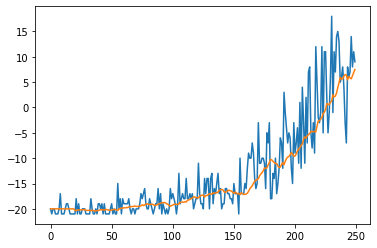

In [131]:
plt.plot(scores)
plt.plot(avg_scores)